In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose

from tqdm import tqdm
from itertools import product
from typing import Union

import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [6]:
temp_data = pd.read_excel("Download_Performance_Raw_Data.xlsx")
#Decrease size of file by removing columns in the sheet!
#Example for columns to stay: Gross weight, Carrier, Incoterm, Domestic/International, Consignee city, Consignee name

In [7]:
temp_data.columns

Index(['Customer', 'TMS ID', 'Customer delivery no.', 'Order no.', 'Job no.',
       'Client', 'Site code', 'Site country', 'Loading location code',
       'Loading location name', 'Loading location country',
       'Loading location city', 'Loading location ZIP code', 'Consignee no.',
       'Consignee name', 'Consignee country', 'Consignee city',
       'Consignee ZIP code', 'Lane', 'Domestic/International', 'Incoterm',
       'Delivery direction', 'Transport mode', 'Service level', 'Carrier',
       'Carrier ID', 'Item quantity', 'Net weight', 'Gross weight',
       'Dangerous goods flag', 'Special delivery', 'Thermo flag',
       'Response needed flag', 'Collection response flag',
       'Delivery response flag', 'Planned pickup date', 'Target pick-up date',
       'Actual pick-up date', 'Planned delivery date', 'Target delivery date',
       'Actual delivery date', 'Accepted shipping forecast date',
       'Confirmed loading date', 'Confirmed delivery date', 'Actual lead time',
  

In [68]:
source_df = temp_data[["Site code", "TMS ID", "Planned pickup date", "Delivery direction", "Gross weight", "Carrier", "Incoterm", "Domestic/International","Consignee city", "Consignee name", "Item quantity"]].copy()
source_df
#source_df.to_csv("site_transports.csv")
# Domestic/International, Consignee city, Consignee name, Carrier

In [9]:
#Formats
df = source_df.copy()

# Sets a datetime object for the variable planned pickup date (shou)
#df['Planned pickup date'] = pd.to_datetime(df['Planned pickup date'])
df['Planned pickup date'] = df['Planned pickup date'].dt.strftime('%Y-%m-%d') # The column needs to be in the datatype datetime.
df['Planned pickup date'] = pd.to_datetime(df['Planned pickup date'])

df.dtypes

Site code                         object
TMS ID                             int64
Planned pickup date       datetime64[ns]
Delivery direction                object
Gross weight                     float64
Carrier                           object
Incoterm                          object
Domestic/International            object
Consignee city                    object
Consignee name                    object
Item quantity                      int64
dtype: object

In [10]:
## Site code only ###

## Achtung, nicht alle Columns wie zB incoterms existieren bei allen sites und können zu fehlern führen

Site_code = 'KBU'
#Delivery_direction='Inbound'

df_sc = df[df['Site code'] == Site_code]
#df_sc =df_sc[df_sc['Delivery direction'] == Delivery_direction]

print(len(df_sc)) #sanity check

# Nur 2 columns



44268


In [11]:
# Extracts the weekday, month, year for possible exogenous variable. Optional.

df_filtered = df_sc.copy()
df_filtered.loc[:,'Weekday'] = df_filtered['Planned pickup date'].dt.dayofweek +1
df_filtered.loc[:,"Month"] = df_filtered["Planned pickup date"].dt.month
df_filtered.loc[:,"Year"] = df_filtered["Planned pickup date"].dt.year


In [12]:
# Only need those columns, weekdays have no statisticially significant effect (learning from a later stage)

df_sc = df_filtered[["Site code", "TMS ID", "Planned pickup date", "Delivery direction", "Gross weight", "Carrier", "Incoterm", "Domestic/International","Consignee city", "Consignee name", "Item quantity", "Year", "Month"]]
df_sc = df_sc.reset_index(drop=True)

print(len(df_sc))

df_sc

44268


,Site code,TMS ID,Planned pickup date,Delivery direction,Gross weight,Carrier,Incoterm,Domestic/International,Consignee city,Consignee name,Item quantity,Year,Month
0,KBU,301583091,2019-01-01,Inbound,24000.0,Cargo-Partner Shuttle,EXW,international,Budapest,HU [0005] Versand Budapest RAIL,33,2019,1
1,KBU,297783950,2019-01-02,Outbound,82.0,Cargo-Partner,CIP,international,Swidnica,Wagony Swidnica sp. z o.o.,1,2019,1
2,KBU,297454709,2019-01-02,Inbound,112.0,Cargo-Partner,EXW,international,Budapest,HU [0005] Versand Budapest RAIL,1,2019,1
3,KBU,296895473,2019-01-02,Inbound,31.2,Cargo-Partner,EXW,international,Budapest,HU [0005] Versand Budapest RAIL,1,2019,1
4,KBU,297499914,2019-01-02,Outbound,422.0,Marway,DAP,international,Weinfelden,Stadler Bussnang AG,2,2019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44263,KBU,498972778,2023-09-22,Inbound,94.0,Bersped,EXW,domestic,Budapest,HU [0005] Versand Budapest RAIL,2,2023,9
44264,KBU,498975319,2023-09-22,Inbound,80.0,Bersped,EXW,domestic,Budapest,HU [0005] Versand Budapest RAIL,2,2023,9
44265,KBU,499201341,2023-09-22,Inbound,1010.0,Bersped,EXW,domestic,Budapest,HU [0005] Versand Budapest RAIL,8,2023,9
44266,KBU,499139358,2023-09-22,Inbound,2048.0,Bersped,EXW,domestic,Budapest,HU [0005] Versand Budapest RAIL,20,2023,9


In [13]:
### Aggregation der TMS ID, auf pickup_date basis

# Hier täglich. Schwer mit zu arbeiten.
#df_grouped = df_sc.groupby("Delivery direction", "Gross weight", "Carrier", "Incoterm", "Domestic/International","Consignee city", "Consignee name", "Item quantity", "Year", "Month").agg({'TMS ID': 'nunique'}).rename(columns={'TMS ID': 'number_tms'})
#df_grouped = df_grouped.reset_index()
#df_grouped = df_grouped.rename(columns={"Planned pickup date": 'pickup_date'})

# Hier auf Monatsebene. 
df_month = df_sc.groupby(["Year","Month"]).agg({"TMS ID": "nunique", "Planned pickup date":"min", "Item quantity": sum, "Gross weight": sum}).rename(columns={'TMS ID': 'number_tms',"Planned pickup date":"pickup_date"})
df_month = df_month.reset_index()             
df_month.head()                                                                                           

,Year,Month,number_tms,pickup_date,Item quantity,Gross weight
0,2019,1,1021,2019-01-01,6473,2965002.31
1,2019,2,964,2019-02-01,6684,3172345.99
2,2019,3,949,2019-03-01,7010,3160027.11
3,2019,4,1007,2019-04-01,6534,3039863.83
4,2019,5,997,2019-05-01,7004,3335577.19


In [15]:
### Monatlich wird verwendet:
df_grouped = df_month
### Geänderte Columns beachten

In [16]:
##Training and testing data, in this case, I only want 2023 as test data and build everything from there
len_2023 = len(df_grouped[df_grouped['pickup_date'].dt.strftime('%Y').str.contains('2023')])
print(len_2023)

train = df_grouped[["pickup_date","number_tms"]][:-len_2023]
test = df_grouped[["pickup_date","number_tms"]][-len_2023:]

print(len(train), len(df_grouped)) #sanity check

target = df_grouped.number_tms
target_train = train.number_tms #nur die number_tms von train
exog = df_grouped[["Month","Year", "Gross weight", "Item quantity"]] #nur exogene variablen. Weekday muss raus bei monatlicher Aggr., hat eh kaum wirkung
exog_train = exog[:-len_2023]

9
48 57


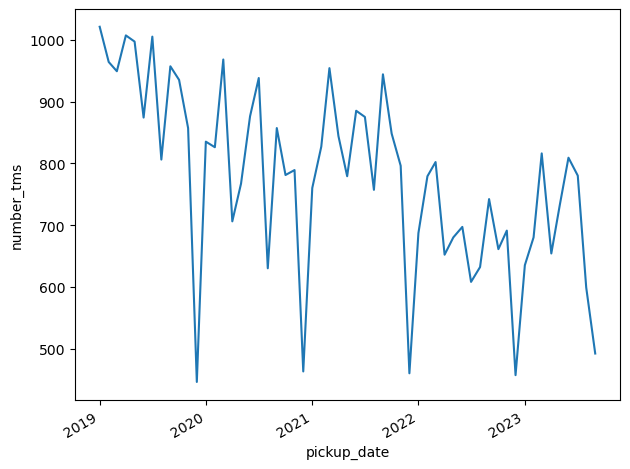

In [17]:
# visualisierung

fig, ax = plt.subplots()

ax.plot(df_grouped.pickup_date, df_grouped.number_tms)
ax.set_xlabel("pickup_date")
ax.set_ylabel("number_tms")

#better visual display
fig.autofmt_xdate() 
plt.tight_layout()

Perform the Augmented Dickey-Fuller (ADF) test on the provided time series data and determine the appropriate order of differencing.

Notes:
    <ul><li>The Augmented Dickey-Fuller (ADF) test is used to determine whether a unit root is present in a time series dataset.</li>
    <li>A unit root indicates that the time series is non-stationary, meaning its statistical properties such as mean and variance are not constant over time.</li>
    <li>The function first applies the ADF test to the original time series data, assessing its stationarity.</li>
    <li>We then manually perform differencing to find the appropriate order of differencing that achieves stationarity.</li>
    <li>Finally, we apply the ADF test again to the differenced data to confirm stationarity.</li>
    

In [396]:
adf_result = adfuller(df_grouped.number_tms)
adf_result

## wenn monatlich, dann ist es noch nicht stationär 


(-0.3897973292017101,
 0.911788371624211,
 11,
 45,
 {'1%': -3.584828853223594,
  '5%': -2.9282991495198907,
  '10%': -2.6023438271604937},
 545.8141748855166)

In [19]:
### Nur händische Differenzierung, um die Höhe herauszufinden. 
diff = np.diff(df_grouped.number_tms, n=2
              )
adfresult=adfuller(diff)
adfresult
# At least for this dataset, 2times differencing has achievend stationarity. d=2

(-4.254868516881369,
 0.0005313134435518896,
 10,
 44,
 {'1%': -3.5885733964124715,
  '5%': -2.929885661157025,
  '10%': -2.6031845661157025},
 523.6703185272472)

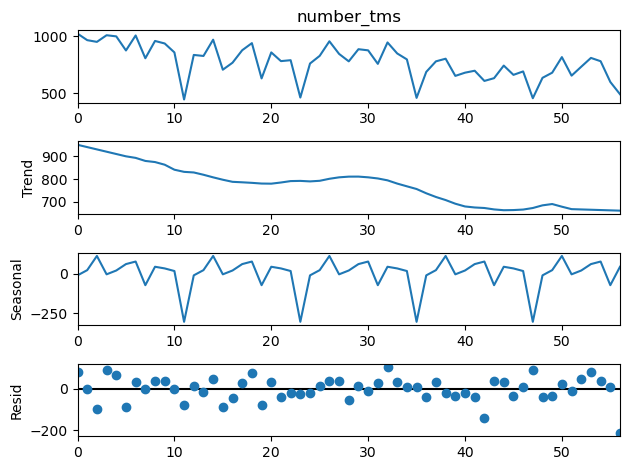

In [20]:
# check for seasonality and if seasonality is stationary

decomp = seasonal_decompose(df_grouped.number_tms, model='additive',extrapolate_trend='freq', period=12)
decomp.plot()

plt.show()


In [21]:
seasonal = decomp.seasonal
adf_result2 = adfuller(seasonal)
adf_result2
#D=0

(-2439371432641756.0,
 0.0,
 11,
 45,
 {'1%': -3.584828853223594,
  '5%': -2.9282991495198907,
  '10%': -2.6023438271604937},
 -2510.3435552547016)

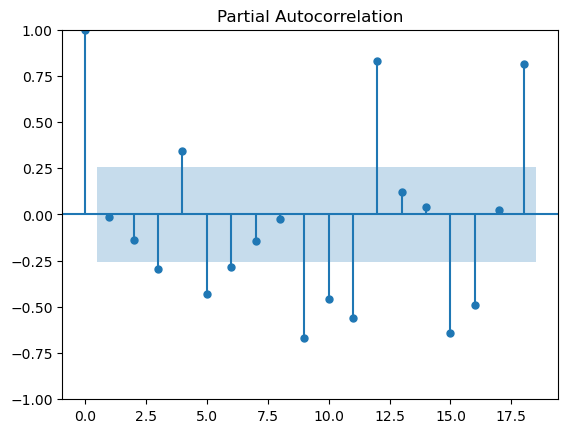

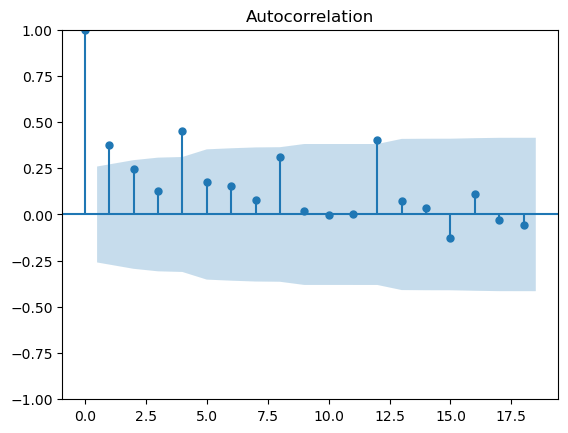

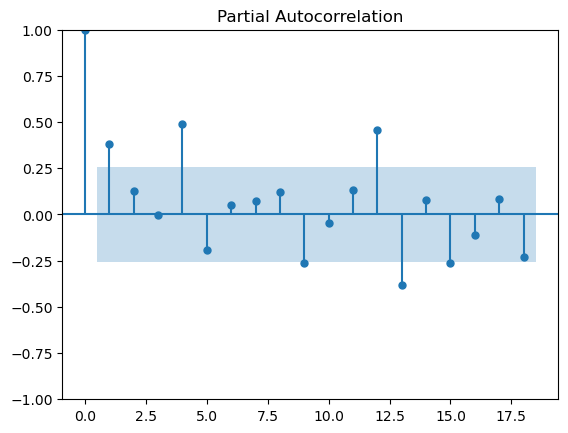

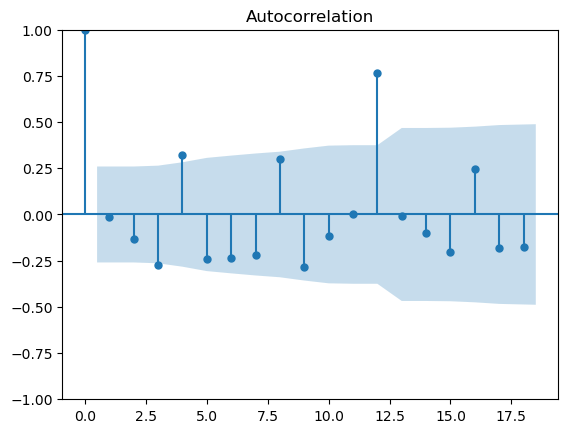

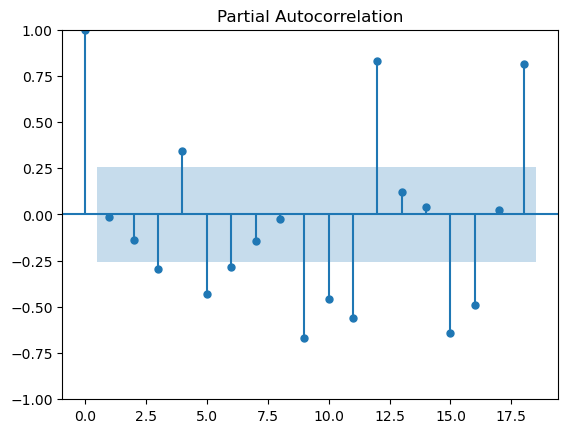

In [22]:
# nice to know
plot_acf(target)
plot_pacf(target)

plot_acf(seasonal)
plot_pacf(seasonal)

In [23]:
#For now, d and D are manually set

def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d:int, D:int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [51]:
p = range(0, 4, 1)
#d = range(0, 2, 1)
d = 2
q = range(0, 4, 1)
P = range(0, 4, 1)
#D = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 12
parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [52]:
# Fehlerquelle: Als Traininsdaten nicht den GANZEN DagtaFrame angeben... kommt nur mopppelkotze bei rum

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [02:24<00:00,  1.77it/s]


,"(p,q,P,Q)",AIC
0,"(2, 1, 3, 3)",20.000000
1,"(2, 2, 1, 1)",116.554898
2,"(3, 1, 1, 0)",563.308027
3,"(3, 2, 2, 0)",563.985701
4,"(0, 2, 1, 0)",564.023739
...,...,...
244,"(2, 0, 0, 0)",626.165511
245,"(1, 0, 0, 0)",626.492827
246,"(0, 0, 3, 3)",627.972645
247,"(0, 0, 0, 1)",630.740259


Absurdly low values can be ignored

In [53]:
#0 	(2, 2, 1, 1) 	116.554898
#1 	(0, 2, 1, 0) 	564.023739

p = 2
d = 2
q = 2
P = 1
D = 0
Q = 1
s = 12

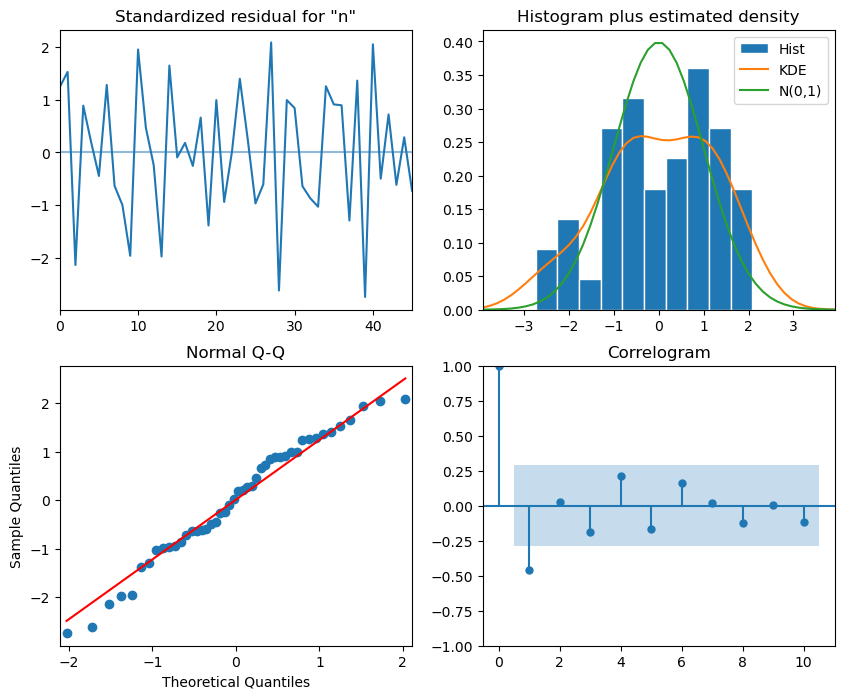

In [54]:
sarimax_model = SARIMAX(target_train, exog_train, order=(p,d,q), seasonal_order=(P,D,Q,s), simple_differencing=False)
sarimax_model_fit = sarimax_model.fit(disp=False)
 
sarimax_model_fit.plot_diagnostics(figsize=(10,8));

In [55]:
residuals = sarimax_model_fit.resid
 
pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(pvalue)

     lb_stat  lb_pvalue
1   6.313575   0.011982
2   6.340873   0.041985
3   6.977407   0.072621
4   7.663467   0.104713
5   7.772438   0.169231
6   7.772460   0.255252
7   7.861934   0.344926
8   8.174100   0.416651
9   8.175958   0.516516
10  8.177276   0.611526


In [56]:
best_model = SARIMAX(target_train, exog_train, order=(p,d,q),seasonal_order=(P,D,Q,s), simple_differencing=False)

best_model_fit = best_model.fit(disp=False)

best_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           number_tms   No. Observations:                   48
Model:             SARIMAX(2, 2, 2)x(1, 0, [1], 12)   Log Likelihood                -273.855
Date:                              Tue, 16 Apr 2024   AIC                            569.710
Time:                                      12:17:13   BIC                            589.825
Sample:                                           0   HQIC                           577.245
                                               - 48                                         
Covariance Type:                                opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Month           -11.3222      4.399     -2.574      0.010     -19.944      -2.701
Year              0.9448     11.648      0.081      0.935     -21.884      23.774
Gross weight      0.0003   2.26e-05     12.039      0.000       0.000       0.000
Item quantity    -0.0036      0.004     -0.908      0.364      -0.011       0.004
ar.L1            -0.0514      4.185     -0.012      0.990      -8.254       8.152
ar.L2             0.4932      3.167      0.156      0.876      -5.713       6.700
ma.L1            -0.1533      4.195     -0.037      0.971      -8.375       8.068
ma.L2            -0.3228      2.316     -0.139      0.889      -4.863       4.217
ar.S.L12          0.2851      0.310      0.921      0.357      -0.322       0.892
ma.S.L12          0.2942      0.347      0.847      0.397      -0.387       0.975
sigma2         4733.3103      0.025   1.86e+05      0.000    4733.260    4733.360
===================================================================================
Ljung-Box (L1) (Q):                  10.29   Jarque-Bera (JB):                 1.53
Prob(Q):                              0.00   Prob(JB):                         0.47
Heteroskedasticity (H):               0.83   Skew:                            -0.31
Prob(H) (two-sided):                  0.72   Kurtosis:                         2.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.79e+21. Standard errors may be unstable.
"""

In [57]:
def rolling_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    print(total_len)

    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in tqdm(range(train_len, total_len, window)):
            #print(f"{i} in {range(train_len, total_len, window)}")
            model = SARIMAX(endog[:i], exog[:i], order=(p,d,q), seasonal_order=(P,D,Q,s), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [58]:
target_train = target[:-len_2023]
target_test = target[-len_2023:]
print(len(target), len(target_train), len(target_test))


pred_df = pd.DataFrame({'actual': target_test})

57 48 9


In [61]:
TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1
print(TRAIN_LEN, HORIZON, len(target), len(exog))
 
pred_last_value = rolling_forecast(target, exog, TRAIN_LEN, HORIZON,  WINDOW, 'last')
#pred_mean = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW,  'mean')
pred_SARIMAX = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')
 
pred_df['pred_last_value'] = pred_last_value
#test['pred_mean'] = pred_mean
#pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df['pred_SARIMAX'] = pred_SARIMAX
pred_df

48 9 57 57
57
57


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.56it/s]


,actual,pred_last_value,pred_SARIMAX
48,635,457,506.763695
49,680,635,698.531277
50,816,680,607.126951
51,654,816,741.861546
52,732,654,789.339662
53,809,732,698.282653
54,780,809,547.547773
55,599,780,874.276260
56,492,599,709.489545


In [62]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

print(mape_last, mape_SARIMAX)

16.88256195951874 22.603697417031196


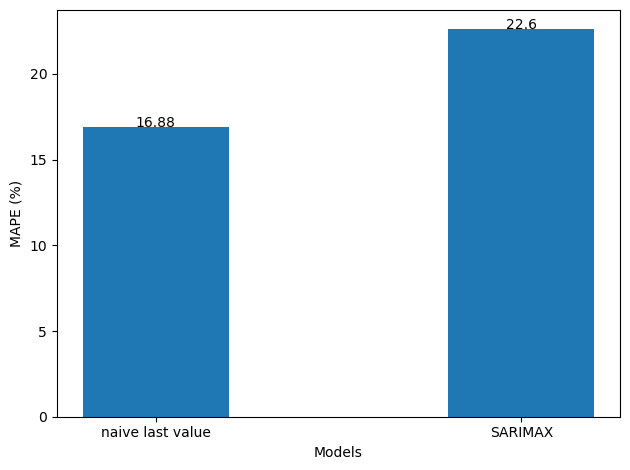

In [64]:
fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
#ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

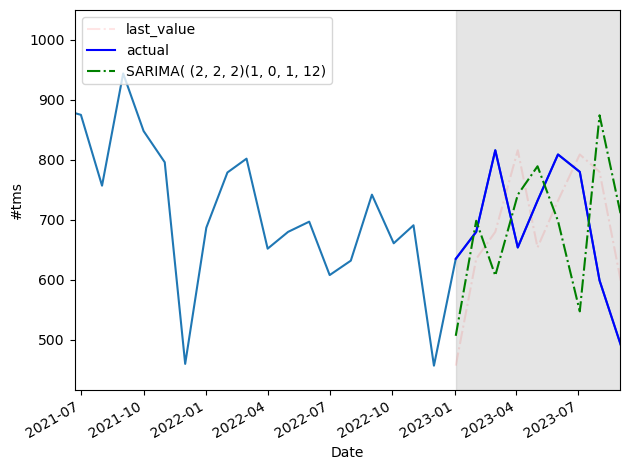

In [66]:
fig, ax = plt.subplots()
 
ax.plot(df_grouped.pickup_date, df_grouped.number_tms)
ax.plot(test.pickup_date, pred_df.pred_last_value, "r-.", label="last_value",  alpha=0.1)
ax.plot(test.pickup_date, pred_df['actual'], 'b-', label='actual')
#ax.plot(test.pickup_date, test['naive_seasonal'], 'r:', label='naive seasonal')
#ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test.pickup_date, pred_df['pred_SARIMAX'], 'g-.', label= f'SARIMA( {p,d,q}{P,D,Q,s}')
 
ax.set_xlabel('Date')
ax.set_ylabel('#tms')
ax.set_xlim(18800, 19600)
ax.axvspan(min(test.pickup_date), max(test.pickup_date), color='#808080', alpha=0.2)
 
ax.legend(loc=2)
 
#plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

 
fig.autofmt_xdate()
plt.tight_layout()

In [169]:
## Correlation between features, just for fun (muss vorher nicht standartisiert werden)

import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = X_all.corr(method='pearson')  # 'pearson' is default

plt.figure(figsize=(30,10))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r')
plt.show() # Wie Sie sehen sehen Sie nichts

NameError: name 'X_all' is not defined

In [67]:
## Between feature and target 

X_y = X_all.copy()
X_y["number_tms"] = y_all
corr_matrix = X_y.corr()
corr_target = corr_matrix[['number_tms']].drop(labels=['number_tms'])
plt.figure(figsize=(8, 6))
sns.heatmap(corr_target, annot=True, fmt='.2', cmap='RdBu_r')
plt.show()

NameError: name 'X_all' is not defined

In [81]:
#override for debugging

#selected_features = ['Inbound']

In [46]:
# Wichtige Zurückverwurstung von X mit feature names, columns 

X_new = X_raw[selected_features]
X_new


#Standartisierung raus?!
#X_scaled = StandardScaler().fit_transform(X_new)
#X_scaled = pd.DataFrame(X_scaled, columns=X_new.columns)  
y = pd.Series(y)  

NameError: name 'X_raw' is not defined

In [104]:
X_scaled.index = X_new.index
#X_scaled

In [53]:
X_new = X_train
grouped = test_grouped

In [54]:
###### BERECHNUNG UND PLOTTEN #########


#TSS parameter, ob das so richtig ist
#length = len(X_new)
n_splits = 12
max_train_size = None
test_size = 1

#fresh start
evaluation_scores = []
all_actual = []
all_predicted = []
fold_dates = []
date_column = grouped.index
test_dates =[]

tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, max_train_size=max_train_size, gap=0) #, max_train_size=max_train_size)


In [209]:
#test
mse_scores = []
window_size = 13

tss = TimeSeriesSplit(n_splits=len(y) - window_size + 1)

for i in range(window_size, len(y)):
    # Create training and testing sets
    X_train = X_new.iloc[:i]
    y_train = y.iloc[:i]
    X_test = X_new.iloc[i:i+1]  # Predict one step ahead
    y_test = y.iloc[i:i+1]

    # Fit the model on the training data
    lr.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = lr.predict(X_test)
    all_actual.extend(y_test)
    all_predicted.extend(y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

# Calculate the overall performance metric (e.g., average MSE)
average_mse = sum(mse_scores) / len(mse_scores)
print(average_mse)

0.08333333333335265


In [57]:
### Train index 0-24 (für die ersten beiden jahre)
### Dann train index + 1 für jeden monat bis 36

for train_index, test_index in tscv.split(X_new):
        
    X_train, X_test = X_new.iloc[train_index], X_new.iloc[test_index]
    y_train, y_test = y_all.iloc[train_index], y_all.iloc[test_index]
    print("TRAIN indices:", train_index, "\n", "TEST indices:", test_index)
    print("\n")
    print(X_test)
    
    
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    
    print("y_pred: ", y_pred)
    print("y_test: ", y_test)
    
    all_actual.extend(y_test)
    all_predicted.extend(y_pred)
    
    test_dates.append(date_column[test_index])
    print("Date: ", date_column[test_index])

    #accuracy = (1-(y_test, y_pred)/y_pred)*100
    #evaluation_scores.append(accuracy)
    
    

TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11] 
 TEST indices: [12]


    Year  Month  Weekday
12  2020      3        3
y_pred:  [61.42424242]
y_test:  12    61
Name: number_tms, dtype: int64
Date:  Int64Index([12], dtype='int64')
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] 
 TEST indices: [13]


    Year  Month  Weekday
13  2020      3        4
y_pred:  [62.98461538]
y_test:  13    55
Name: number_tms, dtype: int64
Date:  Int64Index([13], dtype='int64')
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] 
 TEST indices: [14]


    Year  Month  Weekday
14  2020      3        5
y_pred:  [62.]
y_test:  14    69
Name: number_tms, dtype: int64
Date:  Int64Index([14], dtype='int64')
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
 TEST indices: [15]


    Year  Month  Weekday
15  2020      4        1
y_pred:  [55.6]
y_test:  15    48
Name: number_tms, dtype: int64
Date:  Int64Index([15], dtype='int64')
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 

In [246]:
#### Leakage test ###

X_train = X_new[:24]
X_test =X_new[13:]
y_train = y[:24]
y_test = y[13:]

#y_test

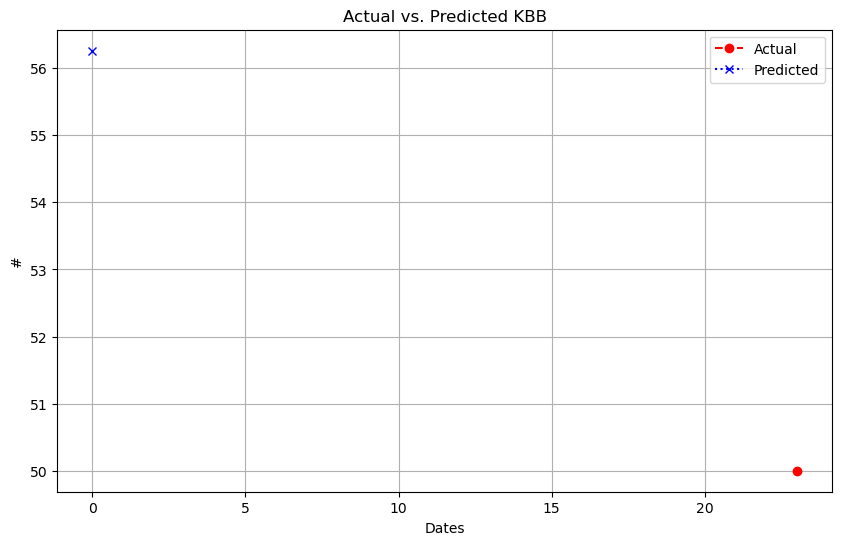

In [58]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
    
plt.figure(figsize=(10, 6))
plt.plot(y_test, color='red', linestyle='--', marker='o', label='Actual')
plt.plot(y_pred, color='blue', linestyle='dotted', marker='x', label='Predicted')
plt.xlabel('Dates')
plt.ylabel('#')
plt.title('Actual vs. Predicted '+ Site_code)
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [59]:
from itertools import chain
test_dates = list(chain.from_iterable(test_dates))
test_dates

### todo explain

[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

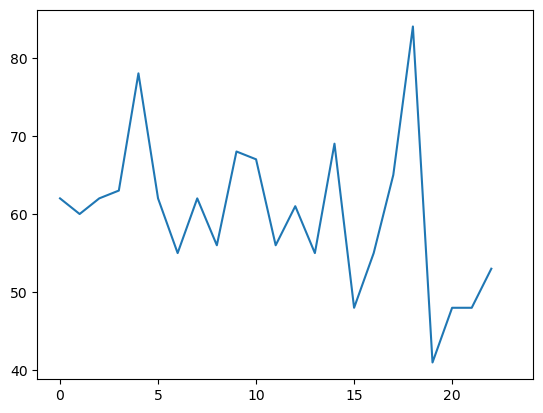

In [60]:
plt.plot(y_train)
plt.plot(y_test)

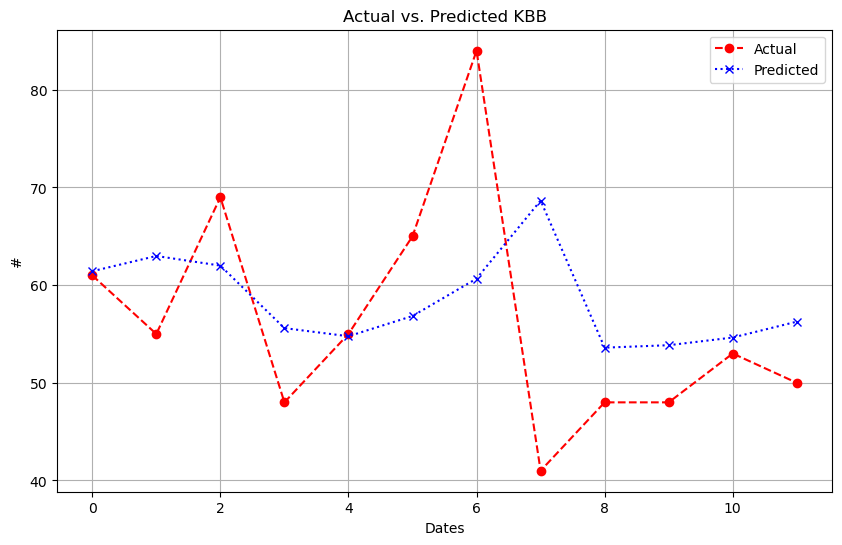

Accuracy Scores for Each Fold: []


In [67]:
plt.figure(figsize=(10, 6))
#plt.plot(y_pred)
plt.plot( all_actual, color='red', linestyle='--', marker='o', label='Actual')
plt.plot( all_predicted, color='blue', linestyle='dotted', marker='x', label='Predicted')
plt.xlabel('Dates')
plt.ylabel('#')
plt.title('Actual vs. Predicted '+ Site_code)
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

print("Accuracy Scores for Each Fold:", evaluation_scores)


In [66]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Absolute Error (MAE): 6.26
Mean Squared Error (MSE): 39.20
Root Mean Squared Error (RMSE): 6.26


In [ ]:
print("Done: ", pd.Timestamp.now())

In [ ]:
#y_pred len9
#y_test len9

